In [ ]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/INF554/project'
%ls

Mounted at /content/drive
/content/drive/My Drive/INF554/project
baseline.py                        prediction_nesima2.txt
constant_predictions.txt           prediction_nesima.txt
data/                              prediction_NN_60-30-15-5-1_alldataset.txt
decisiontree_pca.txt               prediction_NN_60-30-15-5-1.txt
dummy_baseline.py                  prediction_NN_alltext.txt
hist_age.png                       prediction_NN_batch.txt
Log_ROC.png                        prediction_NN_lasthope2.txt
mean_predictions.txt               prediction_NN_lasthope3.txt
{model_bom}                        prediction_NN_lasthope.txt
prediction_decisiontreeall.txt     prediction_NN_urls.txt
prediction_decisiontreesimple.txt  prediction_out.txt
prediction_decisiontree.txt        twitter
prediction_drop_out.txt            twitter.pdf
prediction_lasthope2again.txt


# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import *
from collections import Counter
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

# Open Dataset

Specify here the path to your dataset

In [ ]:
 # main path to our dataset
data_path = "data"
train_path = os.path.join(data_path, 'train.csv')
eval_path = os.path.join(data_path, 'evaluation.csv')

In [ ]:
train_df = pd.read_csv(train_path, index_col='id')
eval_df = pd.read_csv(eval_path, index_col='id')

In [ ]:
train_df.head()

,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
id,,,,,,,,,,
0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up
1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,"Most of us are Human Beings, but I think you m..."
2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,"Old dirty tricks Trump, at it again...like we ..."
3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously..... I worked 86 hours my last check...
4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all. Only ...


# Feature selection and extraction

In [ ]:
# USEFUL FUNCTIONS
def count(df, column):
  """
  Count the number of elements in the column. NaN values are considered 0.
  
  Useful function for count the number of hashtags; links; user mentions
  """
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  df[column].fillna("", inplace=True)
  df[column] = df.apply(lambda x: 0 if x[column] == "" else len(x[column].split(",")), axis=1)
  return df

def analyse_text(df_train, df_eval, column, num_PCA):
  """
  Transform text data into numerical feature by using TfidVectorizer with 100 features maximum.
  After the feature extraction, we realized that reducing the dimension by performing a PCA
  would improve our result, because it reduces the huge amount of noise.

  Useful to analyse Hashtags; text
  """
  if column not in df_train:
    raise Exception("'{}' column not found in the dataframe".format(column))

  df_train[column].fillna("", inplace=True)
  df_eval[column].fillna("", inplace=True)

  # Feature extraction
  vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
  vectorizer.fit(df_train[column])
  text_train = vectorizer.transform(df_train[column]).toarray()
  text_eval = vectorizer.transform(df_eval[column]).toarray()

  # PCA
  pca = PCA(n_components=num_PCA)
  pca.fit(text_train)
  text_train = pca.transform(text_train)
  text_eval = pca.transform(text_eval)

  text_train = pd.DataFrame(text_train, index=df_train.index, columns=[column+"_{}".format(i) for i in range(num_PCA)])
  text_eval = pd.DataFrame(text_eval, index=df_eval.index, columns=[column+"_{}".format(i) for i in range(num_PCA)])

  df_train = pd.concat([df_train, text_train], axis=1, join='inner')
  df_eval = pd.concat([df_eval, text_eval], axis=1, join='inner')

  return df_train, df_eval

## timestamp

To use the column timestamp, we made the two following transformation.

* Get the day of the week that each tweet was posted, after we transform this column into some dummy variables columns.

* Get the time interval each tweet was posted in the day (0-1, 1-2, ... 23-24), after we transform this column into some dummy variables columns.

In [ ]:
def transform_timestamp(df):
  if 'timestamp' not in df:
    raise Exception("'timestamp' column not found in the dataframe")
  # we must divide by 1000 to transform into ms
  df['time'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp']/ 1000).hour, axis=1)
  df['week_day'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp']/ 1000).weekday(), axis=1)
  new_c = {i: '{} - {}'.format(i, i + 1) for i in range(24)}
  dummies = pd.get_dummies(df['time'])
  dummies = dummies.rename(columns=new_c)
  new_c_day = {i: 'week_day_{}'.format(i) for i in range(7)}
  dummies_day = pd.get_dummies(df['week_day'])
  dummies_day = dummies_day.rename(columns=new_c_day)
  df = df.drop(['timestamp', 'time', 'week_day'], axis=1)
  return pd.concat([df, dummies, dummies_day], axis=1, join='inner')

train_df = transform_timestamp(train_df)
eval_df = transform_timestamp(eval_df)

## user_verified

We transformed this binary columns into 0 (False) or 1 (True).

In [ ]:
def transform_user_verified(df):
  if 'user_verified' not in df:
    raise Exception("'user_verified' column not found in the dataframe")
  df['user_verified'] *= 1
  return df
  
train_df = transform_user_verified(train_df)
eval_df = transform_user_verified(eval_df)

## user_mentions

We count the number of user mentions of each tweet.

In [ ]:
train_df = count(train_df, 'user_mentions')
eval_df = count(eval_df, 'user_mentions')

## urls

We count the number of urls of each tweet.

In [ ]:
def transform_urls(df):
  if 'urls' not in df:
    raise Exception("'{}' column not found in the dataframe".format('urls'))
  df["urls"] = df.apply(lambda x: 0 if x["urls"] != x["urls"] else 1, axis=1)
  return df
  
train_df = count(train_df, 'urls')
eval_df = count(eval_df, 'urls')

## hashtags

We perform a feature extraction from the hashtags by using TfidVectorizer and applying a PCA with 40 dimensions in order to reduce the noise and its dimension.

We also count the number of hashtags of each tweet.

In [ ]:
train_df, eval_df = analyse_text(train_df, eval_df, 'hashtags', 40)

train_df = count(train_df, 'hashtags')
eval_df = count(eval_df, 'hashtags')

## text

As for the Hahstag column, we also perform a feature extraction of the tweet texts using 100 features maximum. After it, we perform a PCA with 66 dimensions in order to reduce its dimension and noise, with 66 dimensions we could keep 80% of its variance.

In [ ]:
train_df, eval_df = analyse_text(train_df, eval_df, 'text', 66)

train_df = train_df.drop(['text'], axis=1)
eval_df = eval_df.drop(['text'], axis=1)

# Data Visualization

After performing some data transformation, we will perform some data visualization and some data analysis to see which columns are more relevant to our problem, which is predict the total number of retweets. To make it easier to view, we shall create a new column called "retweet_count_interval", which will contain the range of how many retweets the tweet has had. 

This transformation is basically transform our numerical column into some categorical column, as result it will be easier to visualize retweets distribution.

The ranges are:

- 0: [0, 1[
- 1: [1, 10[
- 2: [10, 100[
- 3: [100, 500[
- 4: [500, 1000[
- 5: [1000, 5000[
- 6: [5000, 10000[
- 7: [10000, 50000[
- 8: [50000, 100000[
- 9: [100000, inf[

In [ ]:
def numerical_to_categorical(df, column, cat):
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  
  df[column+"_interval"] = pd.cut(df[column], bins=cat, right=False)
  ord_enc = OrdinalEncoder()
  df[column+"_interval"] = ord_enc.fit_transform(df[[column+"_interval"]]).astype(int)
  return df

train_df = numerical_to_categorical(train_df, "retweet_count", np.array([0, 1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, np.inf]))
train_df.head(3)

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24,week_day_0,week_day_1,week_day_3,week_day_4,week_day_5,week_day_6,hashtags_0,hashtags_1,...,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46,text_47,text_48,text_49,text_50,text_51,text_52,text_53,text_54,text_55,text_56,text_57,text_58,text_59,text_60,text_61,text_62,text_63,text_64,text_65,retweet_count_interval
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,68460,1101,1226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.040354,-0.014785,...,-0.011753,-0.011375,-0.008842,-0.009958,-0.008726,-0.005279,-0.013317,-0.011077,-0.005578,-0.012113,-0.001622,-0.005128,-0.002018,-0.012413,-0.007426,-0.004699,0.000793,-0.002177,-0.003072,-0.006293,-0.000257,-0.020515,0.003980,-0.016606,-0.011038,-0.016869,-0.003230,0.006180,-0.000136,0.010043,0.005338,0.002906,-0.017457,0.002959,-0.009677,-0.025693,-0.008289,0.011753,0.004606,0
1,0,0,309,51,202,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.040354,-0.014785,...,-0.082433,-0.135507,0.006879,-0.224659,-0.161147,0.836368,0.299573,0.157662,0.054069,0.144431,0.049991,0.035874,0.022680,-0.068374,0.025596,-0.000134,-0.008212,0.010175,-0.023564,0.024464,0.026747,-0.003071,-0.001869,0.000309,0.013244,0.021462,0.001149,0.000445,-0.004269,-0.005551,-0.004878,0.014789,-0.020960,-0.011964,-0.000856,-0.001897,-0.007701,-0.003036,-0.016527,0
2,0,0,3241,1675,2325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,-0.040354,-0.014785,...,-0.073696,0.026640,-0.035850,0.007268,0.003318,-0.040196,-0.021021,-0.014144,-0.011634,0.010115,0.038298,-0.039465,-0.080425,0.108553,0.011131,0.342936,0.095702,0.220696,-0.073659,0.153451,0.054673,0.026222,-0.041053,0.028731,0.022299,0.032932,0.025551,-0.010636,-0.000365,-0.006856,-0.009531,-0.004451,-0.016312,-0.018458,0.002321,0.012507,-0.014491,-0.001377,-0.026051,0


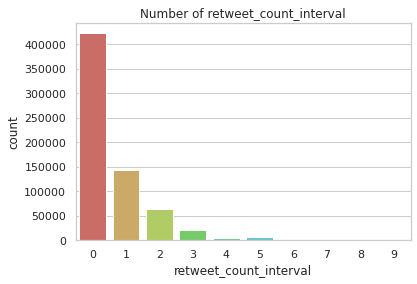

In [ ]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
# Histogram with number of individuals on each category
sns.countplot(x='retweet_count_interval',data=train_df,palette='hls')
plt.title("Number of retweet_count_interval")
plt.show()

Now, we will perform a group by the retweet_count_interval, and we will take the means values of all other columns.

In [ ]:
df_group_cat = train_df.groupby('retweet_count_interval').mean()

## timestamp visualization

First, we visualize week_day variable to see if it is an important variable.

In [ ]:
# DAY OF WEEK
cols = ['week_day_0', 'week_day_1',	'week_day_3',	'week_day_4',	'week_day_5', 'week_day_6']
cols.append('retweet_count_interval')
timestamp_vis = train_df[cols]
timestamp_vis['week_day'] = timestamp_vis[['week_day_0', 'week_day_1',	'week_day_3',	'week_day_4',	'week_day_5', 'week_day_6']].eq(1).idxmax(axis=1)
timestamp_vis.drop(columns=['week_day_0', 'week_day_1',	'week_day_3',	'week_day_4',	'week_day_5', 'week_day_6'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


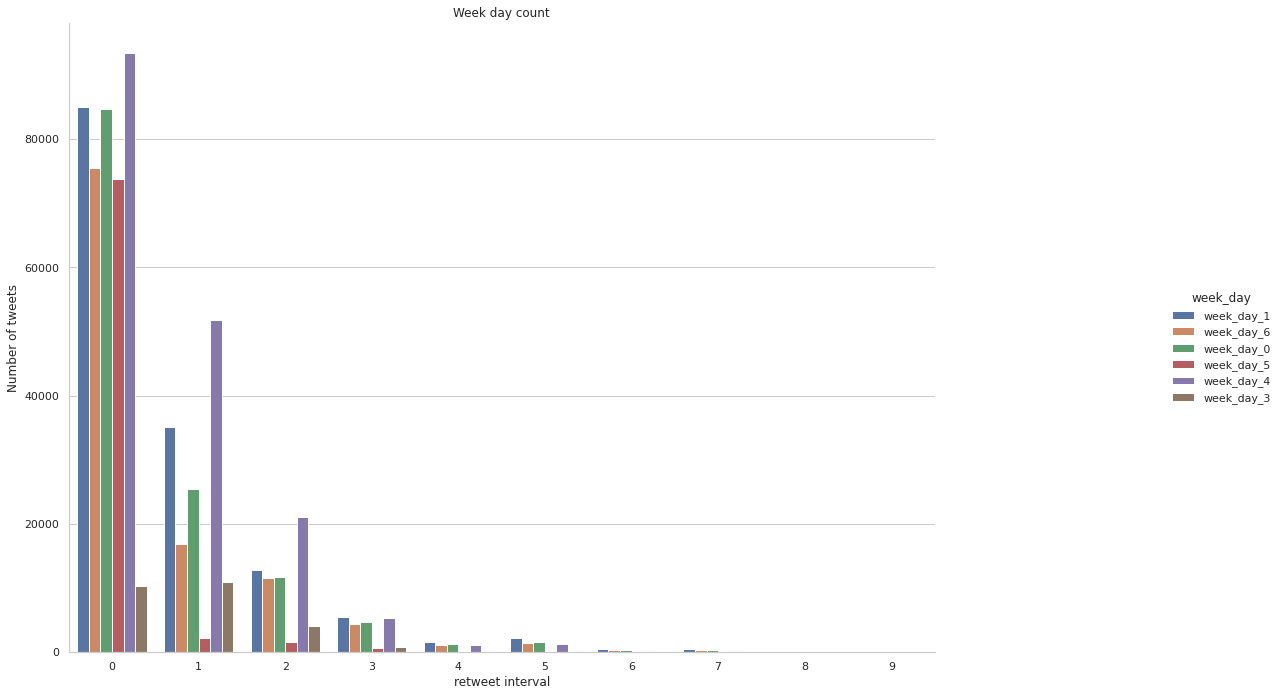

In [ ]:
g = sns.catplot(x='retweet_count_interval', hue='week_day', kind="count", data=timestamp_vis)
g.fig.set_size_inches(20,10)
plt.title("Week day count")
plt.ylabel("Number of tweets")
plt.xlabel("retweet interval")
plt.show()

As we can see from the visualization, the retweet_count_interval count changes when we change the day. So it is an important feature, and we will use it in our model. Now, we will visualize the inteval time of the day when the tweet was posted to see if there is a relation between it and the number of retweets.

In [ ]:
# TIME
cols = ['{} - {}'.format(i, i + 1) for i in range(24)]
cols.append('retweet_count_interval')
timestamp_vis = train_df[cols]
timestamp_vis['time'] = timestamp_vis[['{} - {}'.format(i, i + 1) for i in range(24)]].eq(1).idxmax(axis=1)
timestamp_vis.drop(columns=['{} - {}'.format(i, i + 1) for i in range(24)], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


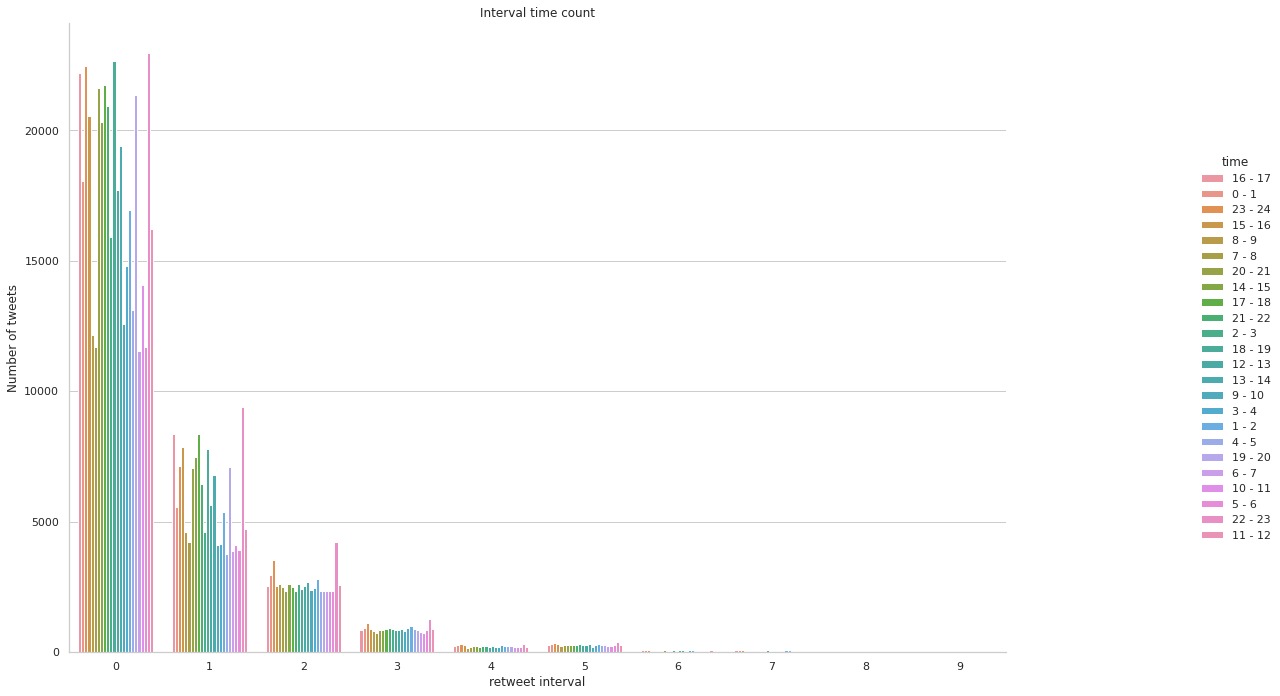

In [ ]:
g = sns.catplot(x='retweet_count_interval', hue='time', kind="count", data=timestamp_vis)
g.fig.set_size_inches(20,10)
plt.title("Interval time count")
plt.ylabel("Number of tweets")
plt.xlabel("retweet interval")
plt.show()

This transformation adds a lot of noise to our dataset, because as we can see from the visualization, it does not really affect the number of retweets. We tried our model with and without this feature, and we increased our results by removing it.

## user_followers_count visualization

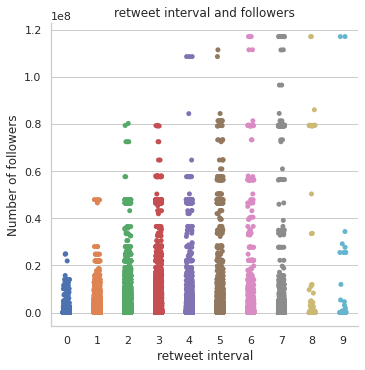

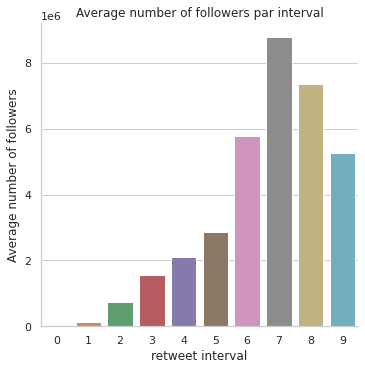

In [ ]:
sns.catplot(x="retweet_count_interval", y="user_followers_count", data=train_df)
plt.title("retweet interval and followers")
plt.ylabel("Number of followers")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="user_followers_count", kind="bar", data=df_group_cat)
plt.title("Average number of followers par interval")
plt.ylabel("Average number of followers")
plt.xlabel("retweet interval")
plt.show()

As we can see from the visualization, tweets made by people with a high number of followers tend to have a greater repercussion than those made by people who have no follower, showing that there is a correlation between those two parameters.

## user_statuses_count visualization

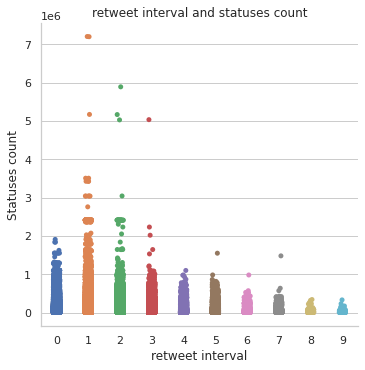

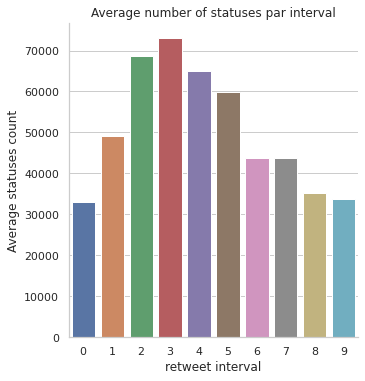

In [ ]:
sns.catplot(x="retweet_count_interval", y="user_statuses_count", data=train_df)
plt.title("retweet interval and statuses count")
plt.ylabel("Statuses count")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="user_statuses_count", kind="bar", data=df_group_cat)
plt.title("Average number of statuses par interval")
plt.ylabel("Average statuses count")
plt.xlabel("retweet interval")
plt.show()

As we can see from the visualization, apart from the outliers that harm the average for each interval, there is a small correlation between the number of statuses count in relation. We noticed that removing these outliers or this column reduce the quality of our model, so we left this column intact.

## user_friends_count visualization

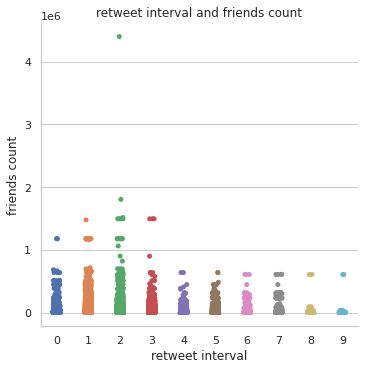

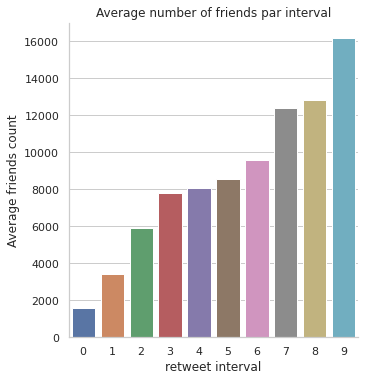

In [ ]:
sns.catplot(x="retweet_count_interval", y="user_friends_count", data=train_df)
plt.title("retweet interval and friends count")
plt.ylabel("friends count")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="user_friends_count", kind="bar", data=df_group_cat)
plt.title("Average number of friends par interval")
plt.ylabel("Average friends count")
plt.xlabel("retweet interval")
plt.show()

Really similar to the statuses_count. A small correlation between number of friends and the number of frieds. We noticed that if we remove outliers, our results get worse, so we also left this column intact.

## user_mentions visualization

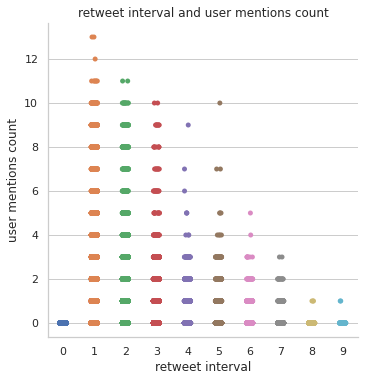

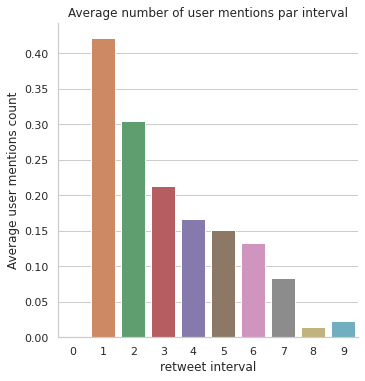

In [ ]:
sns.catplot(x="retweet_count_interval", y="user_mentions", data=train_df)
plt.title("retweet interval and user mentions count")
plt.ylabel("user mentions count")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="user_mentions", kind="bar", data=df_group_cat)
plt.title("Average number of user mentions par interval")
plt.ylabel("Average user mentions count")
plt.xlabel("retweet interval")
plt.show()

It is important to notice that any tweets with at least one user mention, has at least one retweet. Second, it is important to notice that the vast majority of tweets without any user mention, has 0 retweets. So this columns is correlated with the number of retweets. So we leave this column intact.

## urls visualization

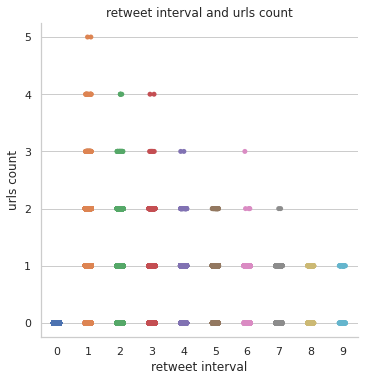

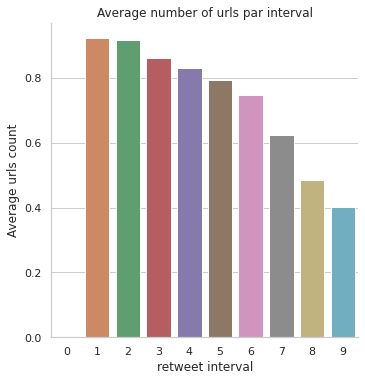

In [ ]:
sns.catplot(x="retweet_count_interval", y="urls", data=train_df)
plt.title("retweet interval and urls count")
plt.ylabel("urls count")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="urls", kind="bar", data=df_group_cat)
plt.title("Average number of urls par interval")
plt.ylabel("Average urls count")
plt.xlabel("retweet interval")
plt.show()

It is really similar to the user mention, any tweet that has at least one url, it has at least one retweet. It is an important column, and we use it intact.

## Hashtags count visualization

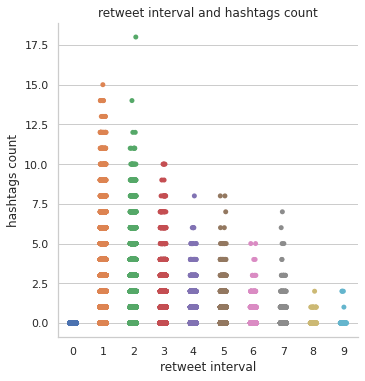

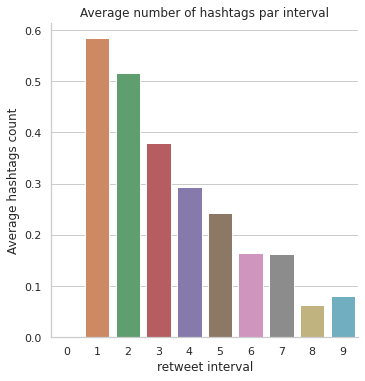

In [ ]:
sns.catplot(x="retweet_count_interval", y="hashtags", data=train_df)
plt.title("retweet interval and hashtags count")
plt.ylabel("hashtags count")
plt.xlabel("retweet interval")
plt.show()

sns.catplot(x=[0,1,2,3,4,5,6,7,8,9], y="hashtags", kind="bar", data=df_group_cat)
plt.title("Average number of hashtags par interval")
plt.ylabel("Average hashtags count")
plt.xlabel("retweet interval")
plt.show()

Similar to use_mention and urls, if it has at least one hashtag, so it has at least one retweet. It is important to see that these three columns decreases at the same rate.

## Correlation between urls, hashtags count and user_mentions

In [ ]:
numerical_vis = train_df[["urls", "hashtags", "user_mentions"]]
numerical_vis.corr()

,urls,hashtags,user_mentions
urls,1.000000,0.327450,0.290947
hashtags,0.327450,1.000000,0.096302
user_mentions,0.290947,0.096302,1.000000


There is a huge correlaton between the number of urls and hashtags, and the number of urls and user_mentions. But the correlation between user_mentions and hashtags is small.

## Correlation between numerical features

In [ ]:
numerical_vis = train_df[["user_statuses_count", "user_followers_count", "user_friends_count", "retweet_count"]]
numerical_vis.corr()

,user_statuses_count,user_followers_count,user_friends_count,retweet_count
user_statuses_count,1.000000,0.172699,0.150665,0.001605
user_followers_count,0.172699,1.000000,0.060272,0.132853
user_friends_count,0.150665,0.060272,1.000000,0.025327
retweet_count,0.001605,0.132853,0.025327,1.000000


As expected, there is a small correlation between the number of retweets and the number of followers count, but there is no correlation between other parameters. So, to use these variables, it is important to use a non-linear method, like Neural Network or Random Forest, because there is no simple relation between them.

# Data preparation

In [ ]:
# Remove interval time columns
train_df.drop(columns=['{} - {}'.format(i, i + 1) for i in range(24)], inplace=True)
eval_df.drop(columns=['{} - {}'.format(i, i + 1) for i in range(24)], inplace=True)

In [ ]:
# Remove retweet_count_interval
train_df.drop(columns=['retweet_count_interval'], inplace=True)

# Check our dataframes

In [ ]:
train_df.head()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,week_day_0,week_day_1,week_day_3,week_day_4,week_day_5,week_day_6,hashtags_0,hashtags_1,hashtags_2,hashtags_3,hashtags_4,hashtags_5,hashtags_6,hashtags_7,hashtags_8,hashtags_9,hashtags_10,hashtags_11,hashtags_12,hashtags_13,hashtags_14,hashtags_15,hashtags_16,hashtags_17,hashtags_18,hashtags_19,hashtags_20,hashtags_21,hashtags_22,hashtags_23,hashtags_24,hashtags_25,...,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46,text_47,text_48,text_49,text_50,text_51,text_52,text_53,text_54,text_55,text_56,text_57,text_58,text_59,text_60,text_61,text_62,text_63,text_64,text_65
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,68460,1101,1226,0,0,0,0,1,0,0,0,0,-0.040354,-0.014785,-0.001365,-0.000772,-0.000864,-0.000387,-0.001023,-0.00074,-0.000616,-0.000667,-0.000194,-0.000355,-0.000328,-0.000491,-0.00015,-0.000191,-0.00008,-0.000317,-0.000376,-0.000101,-0.000207,-0.000199,-0.000217,-0.000074,-0.000282,-0.000186,...,0.009476,-0.011753,-0.011375,-0.008842,-0.009958,-0.008726,-0.005279,-0.013317,-0.011077,-0.005578,-0.012113,-0.001622,-0.005128,-0.002018,-0.012413,-0.007426,-0.004699,0.000793,-0.002177,-0.003072,-0.006293,-0.000257,-0.020515,0.003980,-0.016606,-0.011038,-0.016869,-0.003230,0.006180,-0.000136,0.010043,0.005338,0.002906,-0.017457,0.002959,-0.009677,-0.025693,-0.008289,0.011753,0.004606
1,0,0,309,51,202,0,0,0,0,0,0,0,0,1,-0.040354,-0.014785,-0.001365,-0.000772,-0.000864,-0.000387,-0.001023,-0.00074,-0.000616,-0.000667,-0.000194,-0.000355,-0.000328,-0.000491,-0.00015,-0.000191,-0.00008,-0.000317,-0.000376,-0.000101,-0.000207,-0.000199,-0.000217,-0.000074,-0.000282,-0.000186,...,0.036800,-0.082433,-0.135507,0.006879,-0.224659,-0.161147,0.836368,0.299573,0.157662,0.054069,0.144431,0.049991,0.035874,0.022680,-0.068374,0.025596,-0.000134,-0.008212,0.010175,-0.023564,0.024464,0.026747,-0.003071,-0.001869,0.000309,0.013244,0.021462,0.001149,0.000445,-0.004269,-0.005551,-0.004878,0.014789,-0.020960,-0.011964,-0.000856,-0.001897,-0.007701,-0.003036,-0.016527
2,0,0,3241,1675,2325,0,0,0,1,0,0,0,0,0,-0.040354,-0.014785,-0.001365,-0.000772,-0.000864,-0.000387,-0.001023,-0.00074,-0.000616,-0.000667,-0.000194,-0.000355,-0.000328,-0.000491,-0.00015,-0.000191,-0.00008,-0.000317,-0.000376,-0.000101,-0.000207,-0.000199,-0.000217,-0.000074,-0.000282,-0.000186,...,-0.000713,-0.073696,0.026640,-0.035850,0.007268,0.003318,-0.040196,-0.021021,-0.014144,-0.011634,0.010115,0.038298,-0.039465,-0.080425,0.108553,0.011131,0.342936,0.095702,0.220696,-0.073659,0.153451,0.054673,0.026222,-0.041053,0.028731,0.022299,0.032932,0.025551,-0.010636,-0.000365,-0.006856,-0.009531,-0.004451,-0.016312,-0.018458,0.002321,0.012507,-0.014491,-0.001377,-0.026051
3,0,0,32327,667,304,0,0,0,0,0,0,0,1,0,-0.040354,-0.014785,-0.001365,-0.000772,-0.000864,-0.000387,-0.001023,-0.00074,-0.000616,-0.000667,-0.000194,-0.000355,-0.000328,-0.000491,-0.00015,-0.000191,-0.00008,-0.000317,-0.000376,-0.000101,-0.000207,-0.000199,-0.000217,-0.000074,-0.000282,-0.000186,...,0.007557,-0.002511,-0.007732,-0.012038,-0.023752,-0.008852,-0.016815,-0.011931,-0.008083,-0.000427,-0.052057,-0.018620,-0.003222,-0.018911,0.005444,-0.012375,0.009142,-0.012541,-0.027507,-0.006790,0.021459,0.019985,-0.019816,0.044621,-0.057463,-0.052015,-0.038575,0.030306,-0.021422,0.051964,0.114546,0.063406,0.105298,0.187889,0.290014,0.090218,-0.421248,0.123390,0.065532,-0.340366
4,0,0,581,42,127,0,0,0,1,0,0,0,0,0,-0.040354,-0.014785,-0.001365,-0.000772,-0.000864,-0.000387,-0.001023,-0.00074,-0.000616,-0.000667,-0.000194,-0.000355,-0.000328,-0.000491,-0.00015,-0.000191,-0.00008,-0.000317,-0.000376,-0.000101,-0.000207,-0.000199,-0.000217,-0.000074,-0.000282,-0.000186,...,-0.007175,0.099262,0.031562,0.034583,0.019564,-0.073767,0.003367,-0.080630,0.004

In [ ]:
# shapes
print(train_df.shape)
print(eval_df.shape)

(665777, 120)
(285334, 119)


# Model

## Neural Network

* (119, 75, 30, 15, 5, 1)
* ReLu activation function
* L1 Loss
* Normalization of our dataset
* 20% of our dataset will be transform into a test dataset
* Turn on CUDA device !!


In [ ]:
y = train_df['retweet_count'].to_numpy()
X_df = train_df.drop(['retweet_count'], axis=1)
X = X_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_eval = eval_df.to_numpy()

In [ ]:
# normalize our data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_eval = scaler.transform(X_eval)

mean_y, std_y = np.mean(y_train), np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(119, 70)
        self.l2 = torch.nn.Linear(70, 35)
        self.l3 = torch.nn.Linear(35, 15)
        self.l4 = torch.nn.Linear(15, 5)
        self.l5 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        x =  x * std_y + mean_y
        return x
  
class TweetDataSet(Dataset):
    def __init__(self, X, y, device, mode='Train'):                 
      self.X = X
      self.y = y
      self.mode = mode
      self.device = device

    def __len__(self):
      return len(self.X)
    
    def __getitem__(self, idx):
      x_g = self.X[idx]
      if self.mode == 'Train' or self.mode == "Test":
        y_g = np.expand_dims(self.y[idx], axis=0)
        return torch.from_numpy(x_g).type(torch.cuda.FloatTensor), torch.from_numpy(y_g).float().type(torch.cuda.FloatTensor)
      else:
        return torch.from_numpy(x_g).float().type(torch.cuda.FloatTensor), None

In [ ]:
model = Net()
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

epochs = 20

train_dataset = TweetDataSet(X_train, y_train, torch.device('cuda'))
test_dataset = TweetDataSet(X_test, y_test, torch.device('cuda'))

In [ ]:
def train_epoch(model, opt, loss_func, trainloader):
  # Train each epoch
  model.train()
  losses = []
  for x_batch, y_batch in tqdm(trainloader, total=len(trainloader)):
      opt.zero_grad()
      # Forward
      y_comp = model(x_batch)
      y_batch =  y_batch * std_y + mean_y
      # Compute diff
      loss = loss_func(y_comp.cpu(), y_batch.cpu())
      # Compute gradients
      loss.backward()
      # update weights
      opt.step()
      losses.append(loss.data.numpy())
  return losses

def accuracy(model, testloader):
  # Calculate the loss of our test_dataset
  model.eval()
  total = 0
  div = 0
  for x_batch, y_batch in tqdm(testloader, total=len(testloader)):
      outputs = model(x_batch)
      y_batch =  y_batch * std_y + mean_y
      total += torch.abs(outputs - y_batch).sum().item()
      div += outputs.size(0)
  model.train()
  return total / div

def train(train_dataset, test_dataset, model, loss_func, opt, epochs, scheduler, bs=50):
  # train the model
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs)
  loss_train = []
  loss_test = []
  for i in range(epochs):
    loss_train_epoch = train_epoch(model, opt, loss_func, train_dataloader)
    loss_train.append(sum(loss_train_epoch)/(len(loss_train_epoch)))
    print('epoch {}, loss train {}'.format(i + 1, sum(loss_train_epoch)/(len(loss_train_epoch))))
    loss_test_epoch = accuracy(model, test_dataloader)
    print('epoch {}, loss test {}'.format(i + 1, loss_test_epoch))
    loss_test.append(loss_test_epoch)
    scheduler.step()
  return loss_train, loss_test

In [ ]:
loss_train, loss_test = train(train_dataset, test_dataset, model, loss_func, optimizer, epochs, scheduler, bs=32)

# Evaluation

In [ ]:
model.eval()
y_eval = model(torch.from_numpy(X_eval).type(torch.cuda.FloatTensor))
y_eval = y_eval.cpu().detach().numpy()
y_eval = y_eval.T[0]
y_eval[y_eval < 0] = 0
y_eval = y_eval.astype(int)

In [ ]:
import csv
# Dump the results into a file that follows the required Kaggle template
result = pd.DataFrame()
result['TweetID'] = eval_df.index
result['NoRetweets'] = y_eval
with open("prediction_NN_(119_70_35_15_5_1).txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for idx, row in result.iterrows():
      id = str(row['TweetID'])
      num =  str(int(row['NoRetweets']))
      writer.writerow([id, num])